<a href="https://colab.research.google.com/github/SIDIBEMoussa/Tanzania-Tourism-Prediction/blob/main/Version_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import warnings
warnings.filterwarnings('ignore')

In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


In [89]:
train_path = "https://raw.githubusercontent.com/SIDIBEMoussa/Tanzania-Tourism-Prediction/refs/heads/main/Train.csv"
test_path = "https://raw.githubusercontent.com/SIDIBEMoussa/Tanzania-Tourism-Prediction/refs/heads/main/Test.csv"
sub_data = "https://raw.githubusercontent.com/SIDIBEMoussa/Tanzania-Tourism-Prediction/refs/heads/main/SampleSubmission.csv"

In [90]:
train_set = pd.read_csv(train_path)
test_set = pd.read_csv(test_path)
sub_set = pd.read_csv(sub_data)

In [91]:
train_set.head(3)

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost
0,tour_0,SWIZERLAND,45-64,Friends/Relatives,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,...,No,No,No,No,13.0,0.0,Cash,No,Friendly People,674602.5
1,tour_10,UNITED KINGDOM,25-44,NaN,1.0,0.0,Leisure and Holidays,Cultural tourism,others,Independent,...,No,No,No,No,14.0,7.0,Cash,Yes,"Wonderful Country, Landscape, Nature",3214906.5
2,tour_1000,UNITED KINGDOM,25-44,Alone,0.0,1.0,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,...,No,No,No,No,1.0,31.0,Cash,No,Excellent Experience,3315000.0


In [92]:
def countplot(df,col):
    # Trier le DataFrame par la colonne spécifiée en ordre décroissant de fréquence
    order = df[col].value_counts().index

    plt.rcParams["font.size"] = 6
    plt.figure(figsize=(13,5))

    # Utiliser l'argument 'order' pour spécifier l'ordre des barres
    sns.countplot(x=df[col], order=order)

    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=90)
    plt.show()

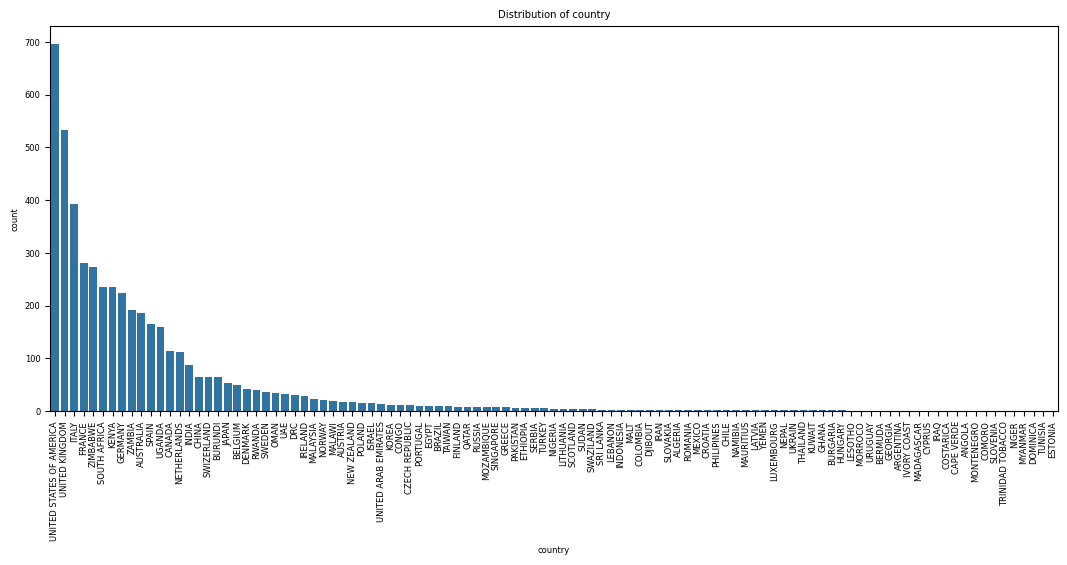

In [93]:
countplot(train_set,"country")

<Axes: ylabel='Density'>

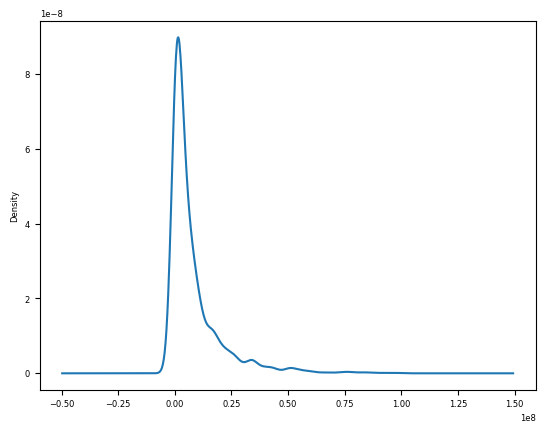

In [94]:
train_set["total_cost"].plot(kind="kde")

In [95]:
cate_cols = train_set.select_dtypes(include="object").columns
train_set[cate_cols] = train_set[cate_cols].astype("category")
test_set[cate_cols] = test_set[cate_cols].astype("category")

In [96]:
X = train_set.drop(["total_cost"],axis=1)
y = train_set["total_cost"]
X_to_fill = pd.concat([X,test_set],axis=0)
X_to_fill = X_to_fill.set_index("ID")

In [97]:
def separate_nan_rows(df,col):
    """Sépare les lignes avec NaN et non-NaN dans un DataFrame pandas.

    Args:
        df: Le DataFrame pandas.

    Returns:
        Un tuple contenant deux DataFrames : le premier avec les lignes contenant des NaN,
        et le second avec les lignes ne contenant pas de NaN.
    """
    nan_rows = df[df[col].isnull()]
    not_nan_rows = df[df[col].notnull()]
    return not_nan_rows,nan_rows

In [98]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

def fillna(df,nan_cols):
    for col in nan_cols:
          train,test = separate_nan_rows(df,col)
          if train[col].dtype == "category":
            le = LabelEncoder()
            train[col] = le.fit_transform(train[col])

          train,y_train = train.drop(nan_cols),train[col]
          test = test.drop(nan_cols)

          train = pd.get_dummies(train,dtype='int')
          test = pd.get_dummies(test,dtype='int')

          rf = RandomForestRegressor()
          rf.fit(train,y_train)
          test[col] = rf.predict(test)
          df = pd.concat([train,test],axis=0)
    return df

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

def fillna(df, nan_cols):
    df_filled = df.copy()  # Créez une copie du DataFrame
    for col in nan_cols:
        train, test = separate_nan_rows(df_filled, col)
        if train[col].dtype == "category":
            le = LabelEncoder()
            train[col] = le.fit_transform(train[col])

        train_X, y_train = train.drop(nan_cols, axis=1), train[col]
        test_X = test.drop(nan_cols, axis=1)

        # Vérifiez si les colonnes sont numériques avant d'utiliser pd.get_dummies
        numerical_cols = train_X.select_dtypes(include=np.number).columns.tolist()
        train_X = pd.get_dummies(train_X[numerical_cols], dtype='int')
        test_X = pd.get_dummies(test_X[numerical_cols], dtype='int')

        # Assurez-vous que train_X et test_X ont les mêmes colonnes
        common_cols = train_X.columns.intersection(test_X.columns)
        train_X = train_X[common_cols]
        test_X = test_X[common_cols]

        rf = RandomForestClassifier()
        rf.fit(train_X, y_train)

        # Stockez les prédictions dans une nouvelle colonne
        test.loc[:, col + '_pred'] = rf.predict(test_X)

        # Concaténez en utilisant l'index
        df_filled = pd.concat([train, test], axis=0).sort_index()

        # Remplacez les valeurs NaN par les prédictions
        df_filled[col] = df_filled[col].fillna(df_filled[col + '_pred'])
        df_filled = df_filled.drop(columns=[col + '_pred'])  # Supprimez la colonne temporaire

    return df_filled

In [100]:
nan_cols = X_to_fill.columns[X_to_fill.isna().any()].tolist()

In [101]:
df_filled = fillna(X_to_fill,nan_cols)

In [102]:
df_filled.head()

,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,...,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing
ID,,,,,,,,,,,,,,,,,,,,,
tour_0,SWIZERLAND,45-64,2.0,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,No,...,No,No,No,No,No,13.0,0.0,Cash,No,2.0
tour_1,AUSTRALIA,45-64,3.0,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,Yes,...,Yes,Yes,Yes,Yes,Yes,10.0,3.0,Cash,Yes,0.0
tour_10,UNITED KINGDOM,25-44,2.0,1.0,0.0,Leisure and Holidays,Cultural tourism,others,Independent,No,...,No,No,No,No,No,14.0,7.0,Cash,Yes,6.0
tour_100,SOUTH AFRICA,25-44,2.0,0.0,4.0,Business,Wildlife tourism,Tanzania Mission Abroad,Package Tour,Yes,...,No,No,No,No,No,13.0,0.0,Cash,No,6.0
tour_1000,UNITED KINGDOM,25-44,0.0,0.0,1.0,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,No,...,No,No,No,No,No,1.0,31.0,Cash,No,1.0


In [103]:
cate_cols = df_filled.select_dtypes(include="object").columns

df_filled[cate_cols] = df_filled[cate_cols].astype("category")

In [104]:
train_data = df_filled.loc[train_set.ID]
test_data = df_filled.loc[test_set.ID]

In [105]:
train_data.head(3)

,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,...,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing
ID,,,,,,,,,,,,,,,,,,,,,
tour_0,SWIZERLAND,45-64,2.0,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,No,...,No,No,No,No,No,13.0,0.0,Cash,No,2.0
tour_10,UNITED KINGDOM,25-44,2.0,1.0,0.0,Leisure and Holidays,Cultural tourism,others,Independent,No,...,No,No,No,No,No,14.0,7.0,Cash,Yes,6.0
tour_1000,UNITED KINGDOM,25-44,0.0,0.0,1.0,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,No,...,No,No,No,No,No,1.0,31.0,Cash,No,1.0


In [106]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4809 entries, tour_0 to tour_999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   country                4809 non-null   category
 1   age_group              4809 non-null   category
 2   travel_with            4809 non-null   float64 
 3   total_female           4809 non-null   float64 
 4   total_male             4809 non-null   float64 
 5   purpose                4809 non-null   category
 6   main_activity          4809 non-null   category
 7   info_source            4809 non-null   category
 8   tour_arrangement       4809 non-null   category
 9   package_transport_int  4809 non-null   category
 10  package_accomodation   4809 non-null   category
 11  package_food           4809 non-null   category
 12  package_transport_tz   4809 non-null   category
 13  package_sightseeing    4809 non-null   category
 14  package_guided_tour    4809 non-null

In [107]:
for col in train_data.select_dtypes(include="category").columns:

    frequency_map = train_data[col].value_counts(normalize=True).to_dict()

    # Étape 2 : Appliquer le frequency encoding sur le train set
    train_data[col] = train_data[col].map(frequency_map)

    # Étape 3 : Appliquer le même mapping sur le test set
    # Les catégories absentes dans le train set seront remplacées par 0
    test_data[col] = test_data[col].map(frequency_map)#.fillna(0)


In [108]:
train_data.head(3)

,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,...,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing
ID,,,,,,,,,,,,,,,,,,,,,
tour_0,0.013308,0.289249,2.0,1.0,1.0,0.590559,0.469744,0.339988,0.534415,0.698066,...,0.571429,0.606987,0.690164,0.677688,0.848201,13.0,0.0,0.86754,0.325639,2.0
tour_10,0.110834,0.517155,2.0,1.0,0.0,0.590559,0.074652,0.101892,0.534415,0.698066,...,0.571429,0.606987,0.690164,0.677688,0.848201,14.0,7.0,0.86754,0.674361,6.0
tour_1000,0.110834,0.517155,0.0,0.0,1.0,0.131628,0.074652,0.339988,0.534415,0.698066,...,0.571429,0.606987,0.690164,0.677688,0.848201,1.0,31.0,0.86754,0.325639,1.0


In [109]:
test_data.head(3)

,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,...,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing
ID,,,,,,,,,,,,,,,,,,,,,
tour_1,0.038677,0.289249,3.0,1.0,1.0,0.590559,0.469744,0.397796,0.465585,0.301934,...,0.428571,0.393013,0.309836,0.322312,0.151799,10.0,3.0,0.86754,0.674361,0.0
tour_100,0.048867,0.517155,2.0,0.0,4.0,0.139530,0.469744,0.014140,0.465585,0.301934,...,0.571429,0.606987,0.690164,0.677688,0.848201,13.0,0.0,0.86754,0.325639,6.0
tour_1001,0.046371,0.517155,2.0,3.0,0.0,0.590559,0.213142,0.339988,0.534415,0.698066,...,0.571429,0.606987,0.690164,0.677688,0.848201,7.0,14.0,0.86754,0.325639,4.0


<Axes: ylabel='Density'>

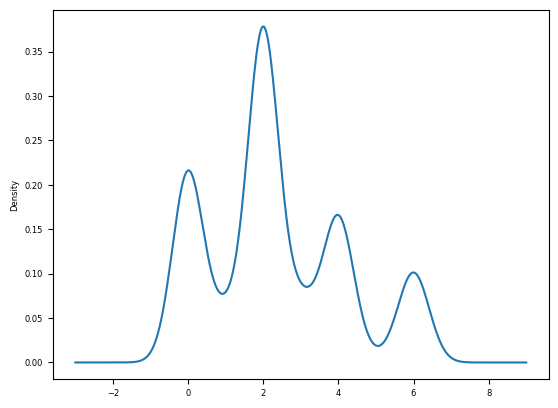

In [110]:
test_data[nan_cols[3]].plot(kind="kde")

In [111]:
import numpy as np
from scipy import stats

def box_cox_shifted(data):
  """
  Applies the Box-Cox transformation with data shifting and optimal lambda selection.

  Args:
    data: A NumPy array or pandas Series containing the data to transform.

  Returns:
    A tuple containing:
      - transformed_data: The transformed data.
      - lambda_value: The optimal lambda value used for the transformation.
  """
  data_shifted = data + abs(data.min()) + 1  # Shift data to be positive
  transformed_data, lambda_value = stats.boxcox(data_shifted)
  return transformed_data, lambda_value

In [112]:
train_data["total_spend"] = y.values

<Axes: >

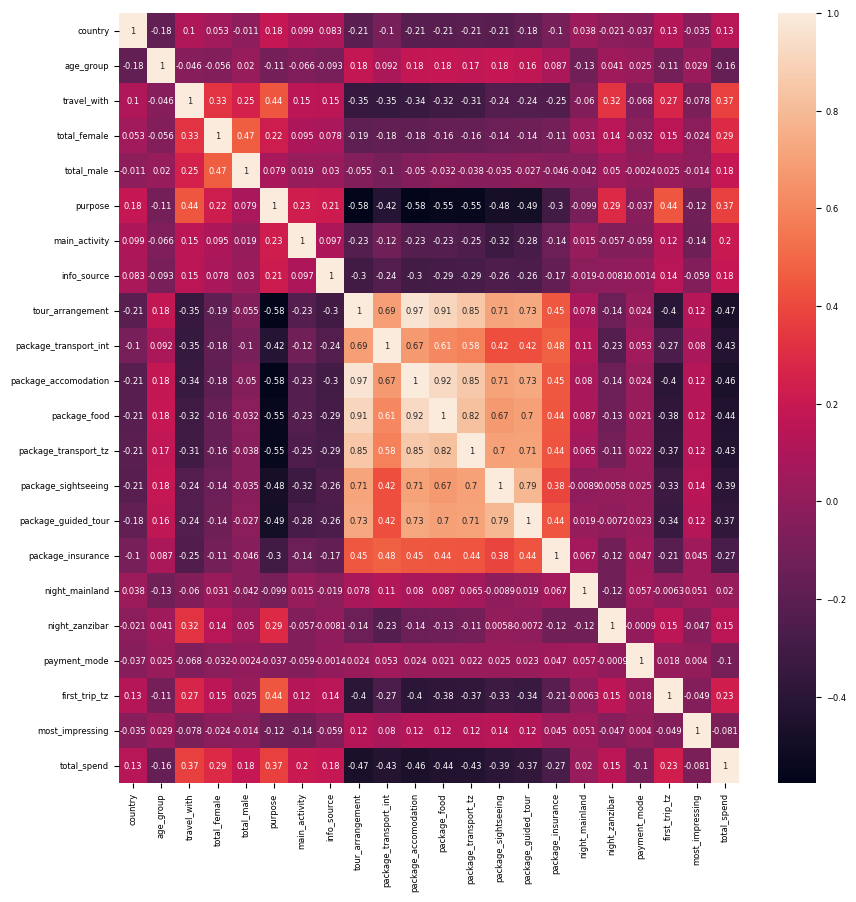

In [113]:
corr = train_data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr,annot=True)

In [114]:
train_data = train_data[train_data["total_male"]<20]

In [115]:
train_data.head(3)

,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,...,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_spend
ID,,,,,,,,,,,,,,,,,,,,,
tour_0,0.013308,0.289249,2.0,1.0,1.0,0.590559,0.469744,0.339988,0.534415,0.698066,...,0.606987,0.690164,0.677688,0.848201,13.0,0.0,0.86754,0.325639,2.0,674602.5
tour_10,0.110834,0.517155,2.0,1.0,0.0,0.590559,0.074652,0.101892,0.534415,0.698066,...,0.606987,0.690164,0.677688,0.848201,14.0,7.0,0.86754,0.674361,6.0,3214906.5
tour_1000,0.110834,0.517155,0.0,0.0,1.0,0.131628,0.074652,0.339988,0.534415,0.698066,...,0.606987,0.690164,0.677688,0.848201,1.0,31.0,0.86754,0.325639,1.0,3315000.0


In [122]:
train_data['night_mainland_log'] = np.log(1+train_data['night_mainland'])
train_data['night_zanzibar_log'] = np.log(1+train_data['night_zanzibar'])

test_data['night_mainland_log'] = np.log(1+test_data['night_mainland'])
test_data['night_zanzibar_log'] = np.log(1+test_data['night_zanzibar'])

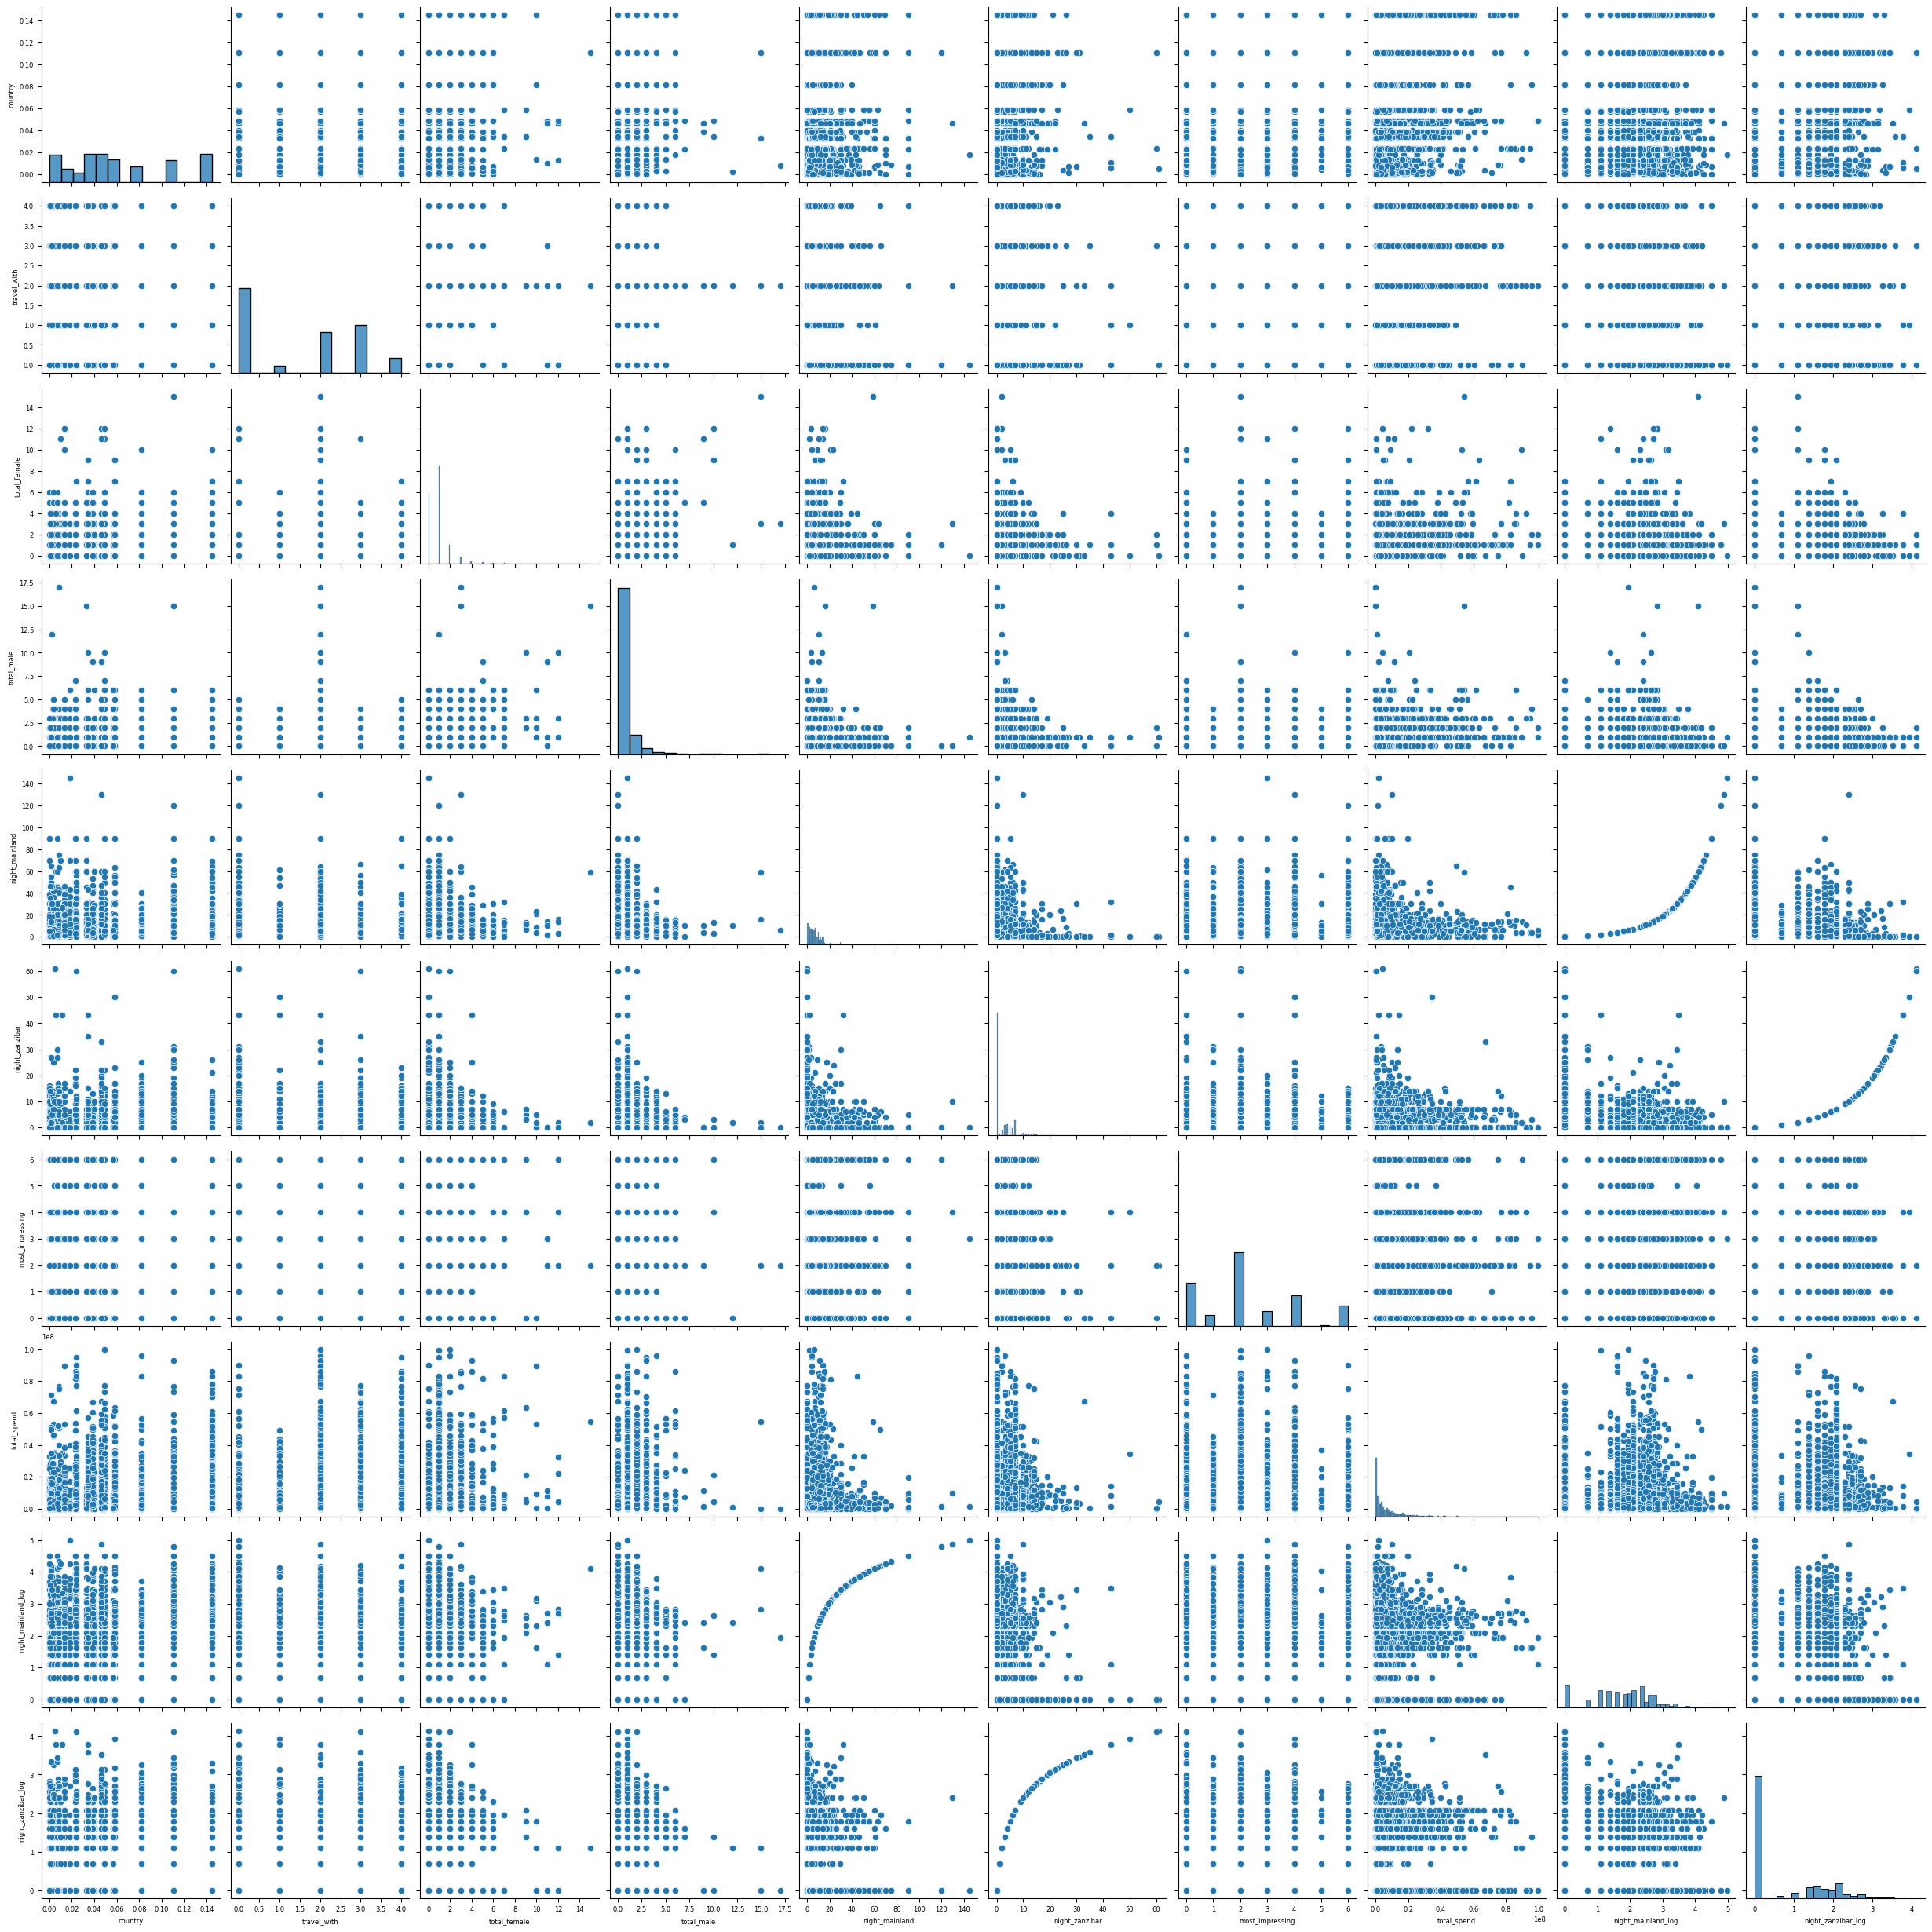

In [123]:
sns.pairplot(train_data[train_data["total_male"]<20])

# Modélisation

In [124]:
X_train,X_test,y_train,y_test = train_test_split(train_data.drop(columns=["total_spend"]),
                                                 train_data["total_spend"],
                                                 test_size=0.2,random_state=42)

In [125]:
rf = RandomForestRegressor(n_estimators=300,max_depth=15,max_features='log2')
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=15, max_features='log2', n_estimators=300)

In [126]:
y_pred = rf.predict(X_test)
print(f"Mean absolute error:{mean_absolute_error(y_test,rf.predict(X_test))}")

Mean absolute error:4884272.1732755955


In [127]:
test_pred = rf.predict(test_data)

In [128]:
sub_set["total_cost"] = test_pred

In [129]:
sub_set.to_csv("submission.csv",index=False)